In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F
import argparse
import matplotlib
from tqdm import tqdm
import glob
from PIL import Image
import os
from datetime import datetime
import time
import math
import sys
sys.path.append("../../src")
from ContrastiveModels import *
from visualization import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.FashionMNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.FashionMNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
activation = hard_sigmoid
criterion = torch.nn.MSELoss(reduction='none').to(device)
architecture = [784, 500, 10]
model = EP(architecture, activation = activation)

In [5]:
lrs = [0.1, 0.05]

In [6]:
optim_params = []
for idx in range(len(model.W)):
    optim_params.append(  {'params': model.W[idx].parameters(), 'lr': lrs[idx]}  )

In [7]:
optimizer = torch.optim.SGD( optim_params, momentum=0.0 )

In [8]:
model = model.to(device)
evaluateEP(model, test_loader, 20, 0.5, device)

Test accuracy :	 0.1026


0.1026

In [9]:
mbs = train_loader.batch_size
start = time.time()
iter_per_epochs = math.ceil(len(train_loader.dataset)/mbs)
betas = (0.0, 1.0)
beta_1, beta_2 = betas
neural_lr = 0.5
train_acc = [10.0]
test_acc = [10.0]
best = 0.0
epoch_sofar = 0
model.train();

In [10]:
trn_acc_list = []
tst_acc_list = []
T1 = 20
T2 = 4
random_sign = True
n_epochs = 25
for epoch_ in range(n_epochs):
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        neurons = model.init_neurons(x.size(0), device)
        neurons = model(x, y, neurons, T1, neural_lr, beta=beta_1, criterion=criterion)
        neurons_1 = copy(neurons)
        if random_sign and (beta_1==0.0):
            rnd_sgn = 2*np.random.randint(2) - 1
            betas = beta_1, rnd_sgn*beta_2
            beta_1, beta_2 = betas

        neurons = model(x, y, neurons, T2, neural_lr, beta = beta_2, criterion=criterion)
        neurons_2 = copy(neurons)
        model.compute_syn_grads(x, y, neurons_1, neurons_2, betas, criterion)
        optimizer.step() 
    trn_acc = evaluateEP(model.to(device), train_loader, T1, neural_lr, device, False)
    tst_acc = evaluateEP(model.to(device), test_loader, T1, neural_lr, device, False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

3000it [02:15, 22.16it/s]
3it [00:00, 20.11it/s]

Epoch : 1, Train Accuracy : 0.8299166666666666, Test Accuracy : 0.8154


3000it [02:16, 22.04it/s]
2it [00:00, 19.23it/s]

Epoch : 2, Train Accuracy : 0.867, Test Accuracy : 0.852


3000it [02:15, 22.08it/s]
2it [00:00, 17.66it/s]

Epoch : 3, Train Accuracy : 0.87755, Test Accuracy : 0.8604


3000it [01:58, 25.37it/s]
4it [00:00, 34.80it/s]

Epoch : 4, Train Accuracy : 0.8731666666666666, Test Accuracy : 0.8517


3000it [01:57, 25.48it/s]
4it [00:00, 35.02it/s]

Epoch : 5, Train Accuracy : 0.8820666666666667, Test Accuracy : 0.8552


3000it [01:19, 37.64it/s]
4it [00:00, 34.10it/s]

Epoch : 6, Train Accuracy : 0.8802333333333333, Test Accuracy : 0.8592


3000it [01:20, 37.25it/s]
4it [00:00, 34.92it/s]

Epoch : 7, Train Accuracy : 0.8881666666666667, Test Accuracy : 0.8592


3000it [01:19, 37.63it/s]
2it [00:00, 16.56it/s]

Epoch : 8, Train Accuracy : 0.8983833333333333, Test Accuracy : 0.8694


3000it [01:20, 37.36it/s]
4it [00:00, 34.01it/s]

Epoch : 9, Train Accuracy : 0.8925333333333333, Test Accuracy : 0.8663


3000it [01:20, 37.05it/s]
4it [00:00, 34.51it/s]

Epoch : 10, Train Accuracy : 0.9023833333333333, Test Accuracy : 0.8709


3000it [01:21, 37.02it/s]
4it [00:00, 34.70it/s]

Epoch : 11, Train Accuracy : 0.8913833333333333, Test Accuracy : 0.8639


3000it [01:19, 37.71it/s]
4it [00:00, 34.49it/s]

Epoch : 12, Train Accuracy : 0.9004833333333333, Test Accuracy : 0.8673


3000it [01:21, 36.76it/s]
4it [00:00, 34.28it/s]

Epoch : 13, Train Accuracy : 0.91155, Test Accuracy : 0.8785


3000it [01:21, 36.65it/s]
4it [00:00, 34.85it/s]

Epoch : 14, Train Accuracy : 0.9040666666666667, Test Accuracy : 0.8726


3000it [01:19, 37.52it/s]
4it [00:00, 34.63it/s]

Epoch : 15, Train Accuracy : 0.9107666666666666, Test Accuracy : 0.8767


3000it [01:21, 36.65it/s]
4it [00:00, 33.95it/s]

Epoch : 16, Train Accuracy : 0.9073666666666667, Test Accuracy : 0.8735


3000it [01:52, 26.62it/s]
2it [00:00, 20.00it/s]

Epoch : 17, Train Accuracy : 0.9096333333333333, Test Accuracy : 0.8759


3000it [02:23, 20.95it/s]
2it [00:00, 20.00it/s]

Epoch : 18, Train Accuracy : 0.9151, Test Accuracy : 0.8779


3000it [02:23, 20.93it/s]
2it [00:00, 18.80it/s]

Epoch : 19, Train Accuracy : 0.9215833333333333, Test Accuracy : 0.8814


3000it [01:33, 32.11it/s]
4it [00:00, 34.03it/s]

Epoch : 20, Train Accuracy : 0.9064666666666666, Test Accuracy : 0.8657


3000it [01:20, 37.11it/s]
4it [00:00, 35.18it/s]

Epoch : 21, Train Accuracy : 0.9152666666666667, Test Accuracy : 0.874


3000it [01:19, 37.80it/s]
4it [00:00, 34.19it/s]

Epoch : 22, Train Accuracy : 0.9244166666666667, Test Accuracy : 0.8845


3000it [01:18, 38.12it/s]
4it [00:00, 32.07it/s]

Epoch : 23, Train Accuracy : 0.9113333333333333, Test Accuracy : 0.8733


3000it [01:19, 37.53it/s]
4it [00:00, 34.90it/s]

Epoch : 24, Train Accuracy : 0.9155166666666666, Test Accuracy : 0.875


3000it [01:19, 37.72it/s]


Epoch : 25, Train Accuracy : 0.9254333333333333, Test Accuracy : 0.881


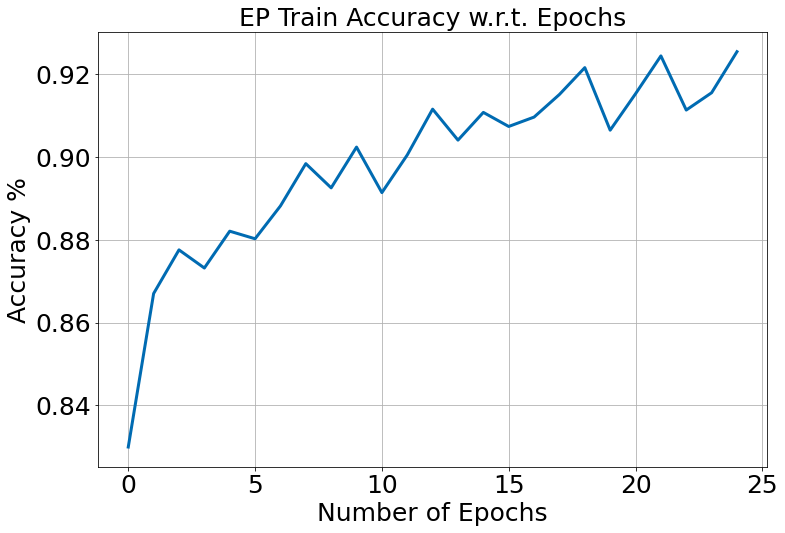

In [11]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'EP Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

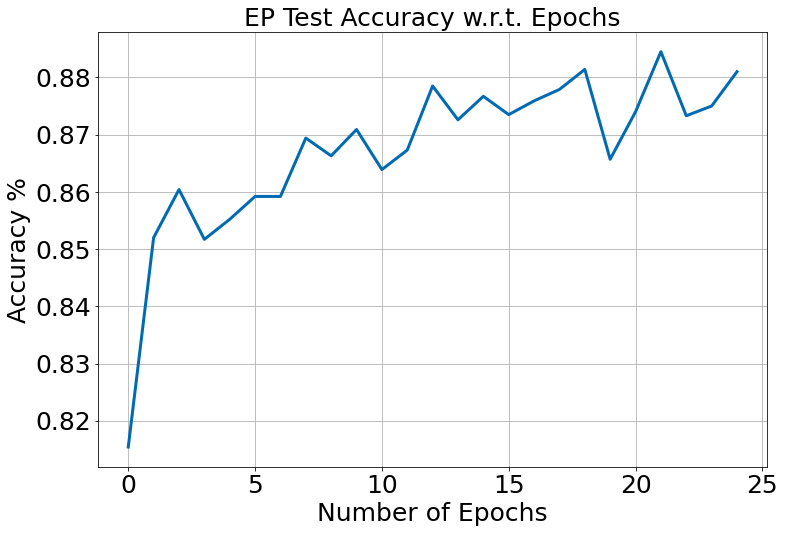

In [12]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'EP Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [13]:
evaluateEP(model.to(device), test_loader, T1, neural_lr, device)

Test accuracy :	 0.881


0.881

In [14]:
evaluateEP(model.to(device), train_loader, T1, neural_lr, device)

Train accuracy :	 0.9254333333333333


0.9254333333333333